In [1]:
import glob
import csv
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt

re_date = re.compile(r'.*/(\d{2})-(\d{2})-(\d{4})\.csv$')

raw_data = []
for filename in glob.glob("../csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
    m = re_date.match(filename)
    mm,dd,yy = [int(x) for x in m.groups()]
    d = np.datetime64(datetime.datetime(year=yy,month=mm,day=dd))
    with open(filename) as f:
        c = csv.reader(f)
        data = list(c)
        print(d, data[0], len(data))
        raw_data.append((d, data[1:]))
raw_data.sort()

2020-02-18T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 76
2020-02-10T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 73
2020-02-25T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 95
2020-02-01T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 68
2020-02-02T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 68
2020-03-08T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered', 'Latitude', 'Longitude'] 256
2020-01-24T00:00:00.000000 ['\ufeffProvince/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 42
2020-03-02T00:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered', 'Latitude', 'Longitude'] 14

In [2]:
print(raw_data[-1][1])

[['Hubei', 'China', '2020-03-16T14:38:45', '67798', '3099', '55142', '30.9756', '112.2707'], ['', 'Italy', '2020-03-16T17:33:03', '27980', '2158', '2749', '41.8719', '12.5674'], ['', 'Iran', '2020-03-16T14:38:45', '14991', '853', '4590', '32.4279', '53.6880'], ['', 'Spain', '2020-03-16T20:13:11', '9942', '342', '530', '40.4637', '-3.7492'], ['', 'Korea, South', '2020-03-16T14:38:45', '8236', '75', '1137', '35.9078', '127.7669'], ['', 'Germany', '2020-03-16T20:13:11', '7272', '17', '67', '51.1657', '10.4515'], ['France', 'France', '2020-03-16T20:13:11', '6633', '148', '12', '46.2276', '2.2137'], ['', 'Switzerland', '2020-03-15T18:20:18', '2200', '14', '4', '46.8182', '8.2275'], ['United Kingdom', 'United Kingdom', '2020-03-16T19:13:13', '1543', '55', '20', '55.3781', '-3.4360'], ['Netherlands', 'Netherlands', '2020-03-16T14:38:46', '1413', '24', '2', '52.1326', '5.2913'], ['Guangdong', 'China', '2020-03-16T01:53:03', '1361', '8', '1306', '23.3417', '113.4244'], ['', 'Norway', '2020-03-1

In [3]:
COUNTRY_RENAMES = {'Mainland China': 'China', 'South Korea': 'Korea, South'}
US_STATE_CODES = {'CA': 'California', 'WA': 'Washington', 'MA': 'Massachusetts', 'NY': 'New York', 'FL': 'Florida'}
def reg(region, country):
    country = COUNTRY_RENAMES.get(country, country)
    if country == 'US':
        m = re.match('.*, (..)$', region)
        if m:
            region=m.group(1)
            region=US_STATE_CODES.get(region, region)
    return region, country
# TODO: regularize US regions to states

In [4]:
def tier(region, country):
    if country in ['Others','Cruise Ship']:
        return 3
    if country != 'China':
        return 2
    if region != 'Hubei':
        return 1
    return 0

In [5]:
all_regions = set()
for _,d in raw_data:
    for line in d:
        r,c = reg(line[0], line[1])
        all_regions.add((tier(r,c),c,r))
print(sorted(all_regions))

[(0, 'China', 'Hubei'), (1, 'China', 'Anhui'), (1, 'China', 'Beijing'), (1, 'China', 'Chongqing'), (1, 'China', 'Fujian'), (1, 'China', 'Gansu'), (1, 'China', 'Guangdong'), (1, 'China', 'Guangxi'), (1, 'China', 'Guizhou'), (1, 'China', 'Hainan'), (1, 'China', 'Hebei'), (1, 'China', 'Heilongjiang'), (1, 'China', 'Henan'), (1, 'China', 'Hong Kong'), (1, 'China', 'Hunan'), (1, 'China', 'Inner Mongolia'), (1, 'China', 'Jiangsu'), (1, 'China', 'Jiangxi'), (1, 'China', 'Jilin'), (1, 'China', 'Liaoning'), (1, 'China', 'Macau'), (1, 'China', 'Ningxia'), (1, 'China', 'Qinghai'), (1, 'China', 'Shaanxi'), (1, 'China', 'Shandong'), (1, 'China', 'Shanghai'), (1, 'China', 'Shanxi'), (1, 'China', 'Sichuan'), (1, 'China', 'Tianjin'), (1, 'China', 'Tibet'), (1, 'China', 'Xinjiang'), (1, 'China', 'Yunnan'), (1, 'China', 'Zhejiang'), (2, ' Azerbaijan', ''), (2, 'Afghanistan', ''), (2, 'Albania', ''), (2, 'Algeria', ''), (2, 'Andorra', ''), (2, 'Antigua and Barbuda', ''), (2, 'Argentina', ''), (2, 'Armeni

In [6]:
dates = np.array([v[0] for v in raw_data], dtype=np.datetime64)
def zeroifempty(x):
    if x=="": return 0
    return int(x)
def cases_by_tier(table, ix):
    c = [0,0,0,0]
    for line in table:
        t=tier(*reg(line[0], line[1]))
        c[t]+=zeroifempty(line[ix])
    return c
def summary_by_tier(table):
    return cases_by_tier(table, 3)+cases_by_tier(table, 4)+cases_by_tier(table,5)

In [7]:
summary = np.array([summary_by_tier(v[1]) for v in raw_data])
print(summary)

[[  444   103     8     0    17     0     0     0    28     0     0     0]
 [  444   195    14     0    17     1     0     0    28     2     0     0]
 [  549   367    25     0    24     2     0     0    31     5     0     0]
 [  761   638    39     0    40     2     0     0    32     7     0     0]
 [ 1058  1004    56     0    52     4     0     0    42     7     3     0]
 [ 1423  1440    64     0    76     6     0     0    45    13     3     0]
 [ 3554  1940    84     0   125     6     0     0    80    21     6     0]
 [ 3554  2516    95     0   125     8     0     0    88    32     6     0]
 [ 4903  3221   111     0   162     9     0     0    90    45     8     0]
 [ 5806  3977   142     0   204     9     0     0   141    73     8     0]
 [ 7153  4718   167     0   249    10     0     0   168   107     9     0]
 [11177  5430   180     0   350    11     1     0   295   168     9     0]
 [13522  6171   188     0   414    11     1     0   386   228     9     0]
 [16678  7002   212     0

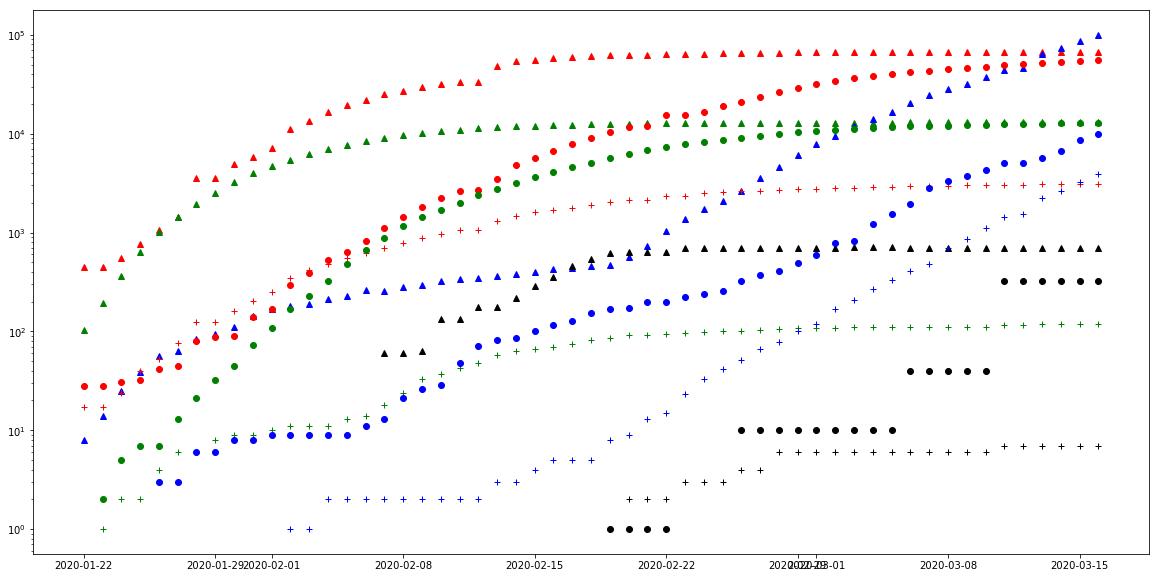

In [8]:
plt.figure(figsize=(20,10))
plt.yscale("log")
markers=['r^', 'g^', 'b^', 'k^', 'r+', 'g+', 'b+', 'k+', 'ro', 'go', 'bo', 'ko']
for i in range(len(markers)):
    plt.plot_date(dates, summary[:,i], markers[i], xdate=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


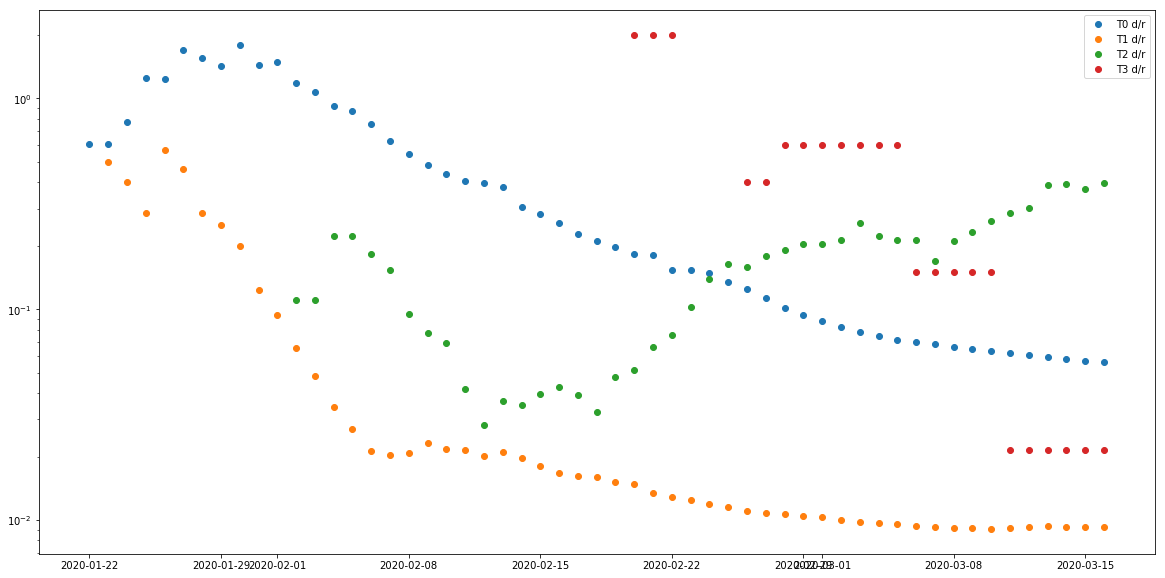

In [9]:
plt.figure(figsize=(20,10))
plt.plot_date(dates, (summary[:,4:8]/summary[:,8:12]))
plt.yscale("log")
plt.legend(["T0 d/r", "T1 d/r", "T2 d/r", "T3 d/r"])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


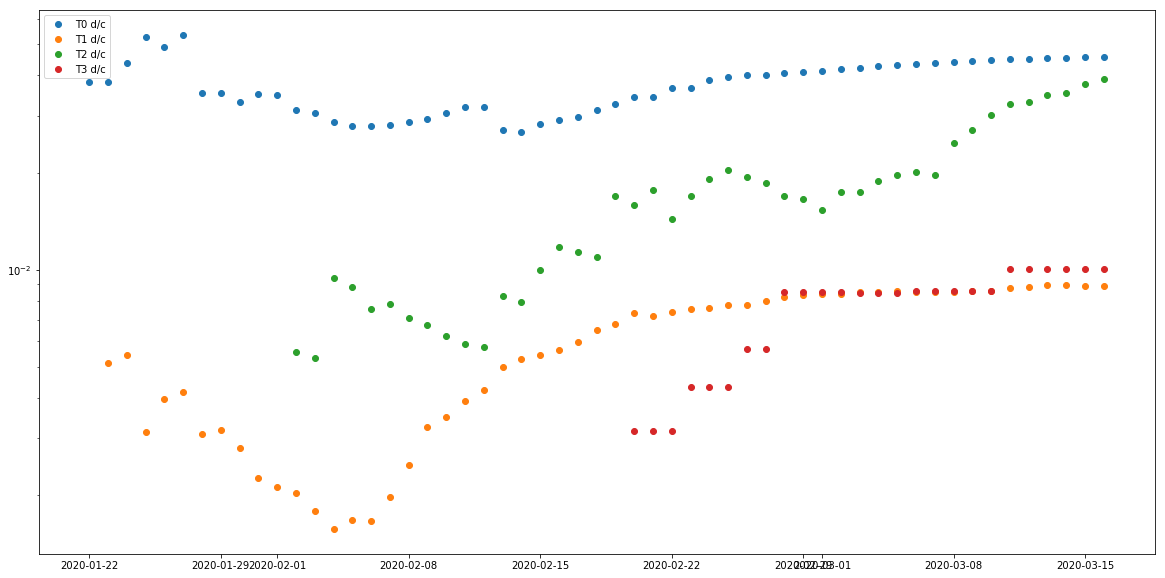

In [10]:
plt.figure(figsize=(20,10))
plt.plot_date(dates, summary[:,4:8]/summary[:,0:4])
plt.yscale("log")
plt.legend(["T0 d/c", "T1 d/c", "T2 d/c", "T3 d/c"])

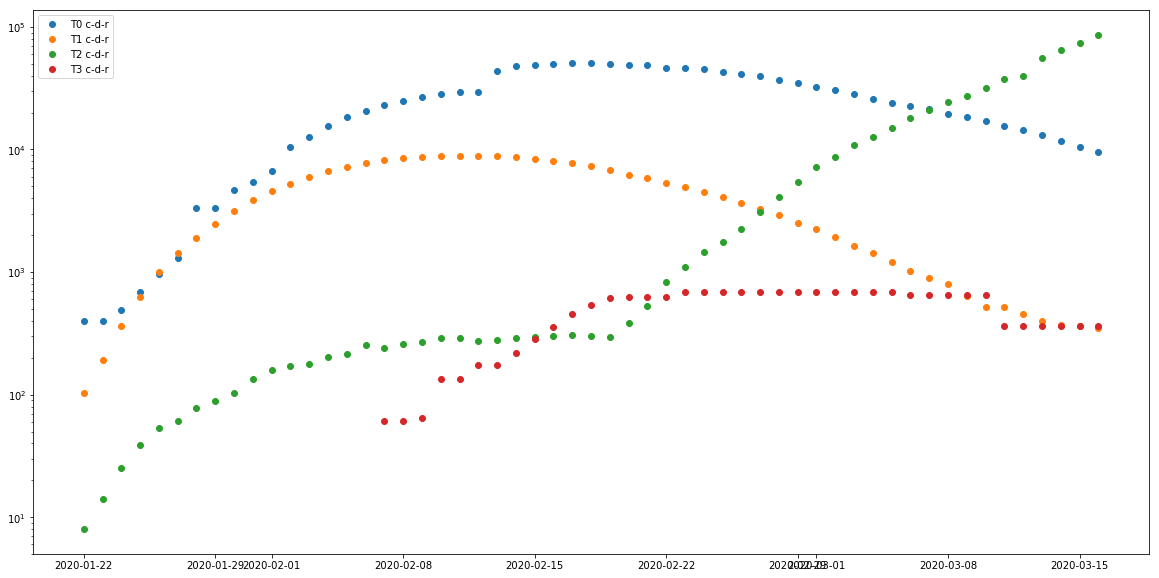

In [11]:
plt.figure(figsize=(20,10))
plt.plot_date(dates, summary[:,0:4]-summary[:,4:8]-summary[:,8:12])
plt.yscale("log")
plt.legend(["T0 c-d-r", "T1 c-d-r", "T2 c-d-r", "T3 c-d-r"])

In [12]:
double_days = 7*np.log(2)/np.log(summary[-1,:] / summary[-8,:])
print(double_days)

[5.97862725e+03 2.61832420e+02 4.28285980e+00            inf
 1.62797558e+02 9.29761471e+01 3.23306749e+00 3.14758927e+01
 2.84214059e+01 1.16464477e+02 5.00470981e+00 2.31606490e+00]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [13]:
def extract_region(region, country):
    region, country = reg(region, country)
    times, values = [], []
    for t,table in raw_data:
        val = []
        for line in table:
            r,c = reg(line[0], line[1])
            if (r==region or not region) and c==country:
                val.append([zeroifempty(x) for x in line[3:6]])
        if val:
            times.append(t)
            values.append(np.sum(val, axis=0))
    times = np.array(times, dtype=np.datetime64)
    values = np.array(values)
    return times,values

In [14]:
HB=extract_region('Hubei', 'China') #1
GD=extract_region('Guangdong', 'China') #2
ZJ=extract_region('Zhejiang', 'China') #4
JS=extract_region('Jiangsu', 'China') #8
SH=extract_region('Shanghai', 'China') #15

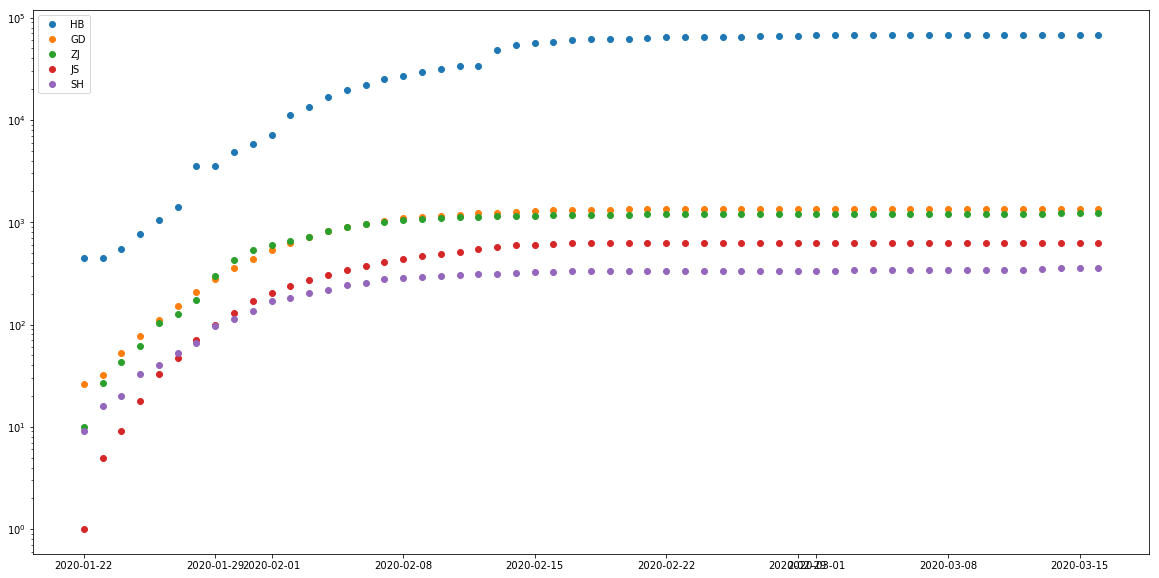

In [15]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 0])
plt.plot_date(GD[0], GD[1][:, 0])
plt.plot_date(ZJ[0], ZJ[1][:, 0])
plt.plot_date(JS[0], JS[1][:, 0])
plt.plot_date(SH[0], SH[1][:, 0])
plt.yscale("log")
plt.legend(["HB", "GD", "ZJ", "JS", "SH"])

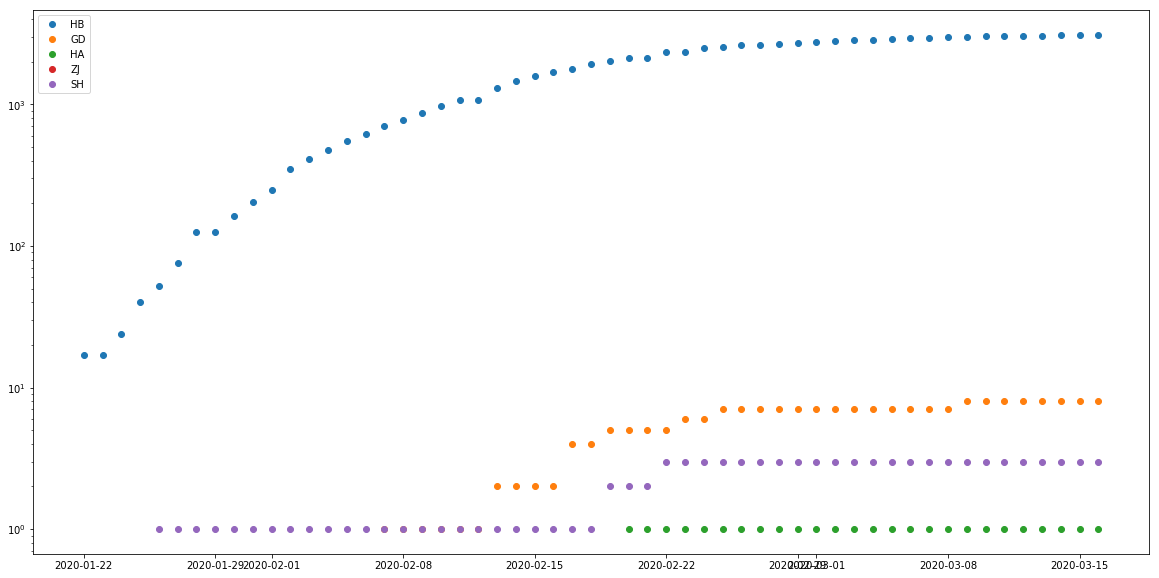

In [16]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 1])
plt.plot_date(GD[0], GD[1][:, 1])
plt.plot_date(ZJ[0], ZJ[1][:, 1])
plt.plot_date(JS[0], JS[1][:, 1])
plt.plot_date(SH[0], SH[1][:, 1])
plt.yscale("log")
plt.legend(["HB", "GD","HA", "ZJ", "SH"])

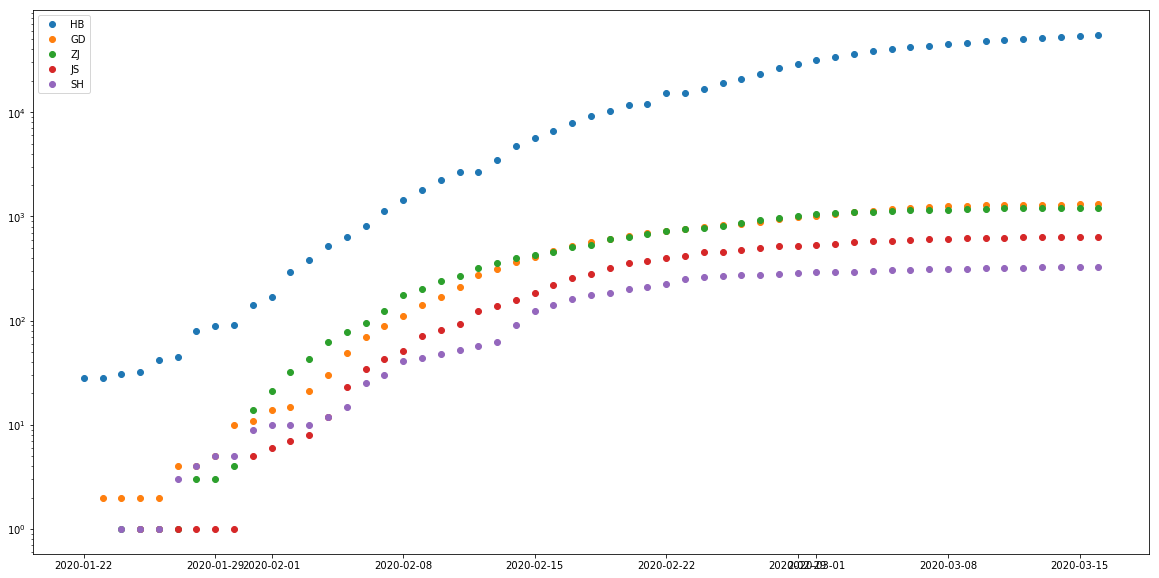

In [17]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 2])
plt.plot_date(GD[0], GD[1][:, 2])
plt.plot_date(ZJ[0], ZJ[1][:, 2])
plt.plot_date(JS[0], JS[1][:, 2])
plt.plot_date(SH[0], SH[1][:, 2])
plt.yscale("log")
plt.legend(["HB", "GD", "ZJ", "JS", "SH"])

In [18]:
KOR=extract_region('', 'Korea, South')
JAP=extract_region('', 'Japan')
ITA=extract_region('', 'Italy')
USA=extract_region('', 'US')

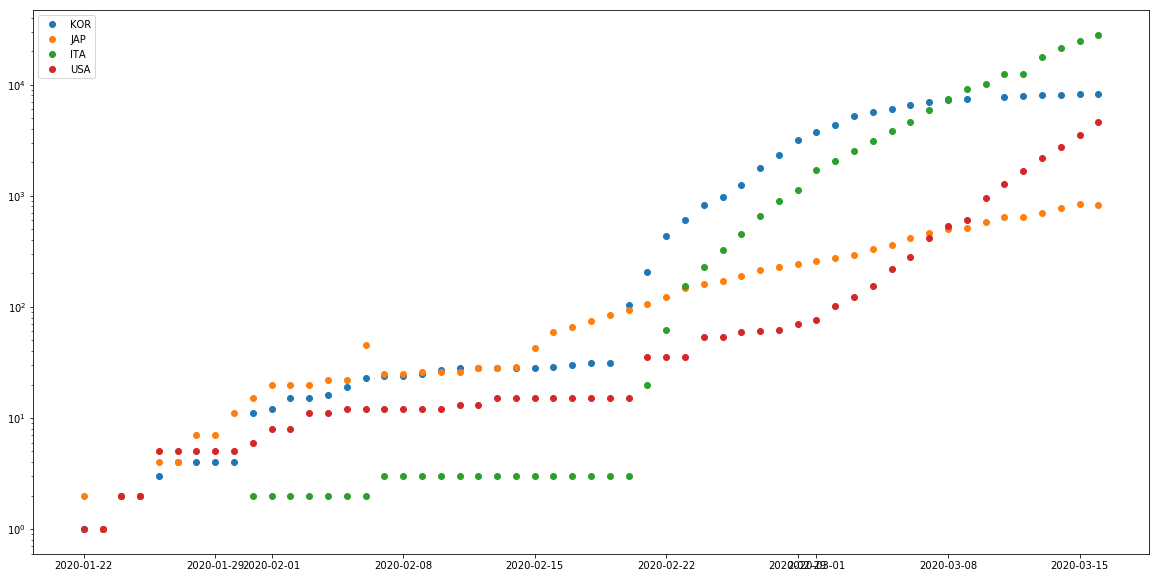

In [19]:
plt.figure(figsize=(20,10))
plt.plot_date(KOR[0], KOR[1][:, 0])
plt.plot_date(JAP[0], JAP[1][:, 0])
plt.plot_date(ITA[0], ITA[1][:, 0])
plt.plot_date(USA[0], USA[1][:, 0])
plt.yscale("log")
plt.legend(["KOR", "JAP", "ITA", "USA"])

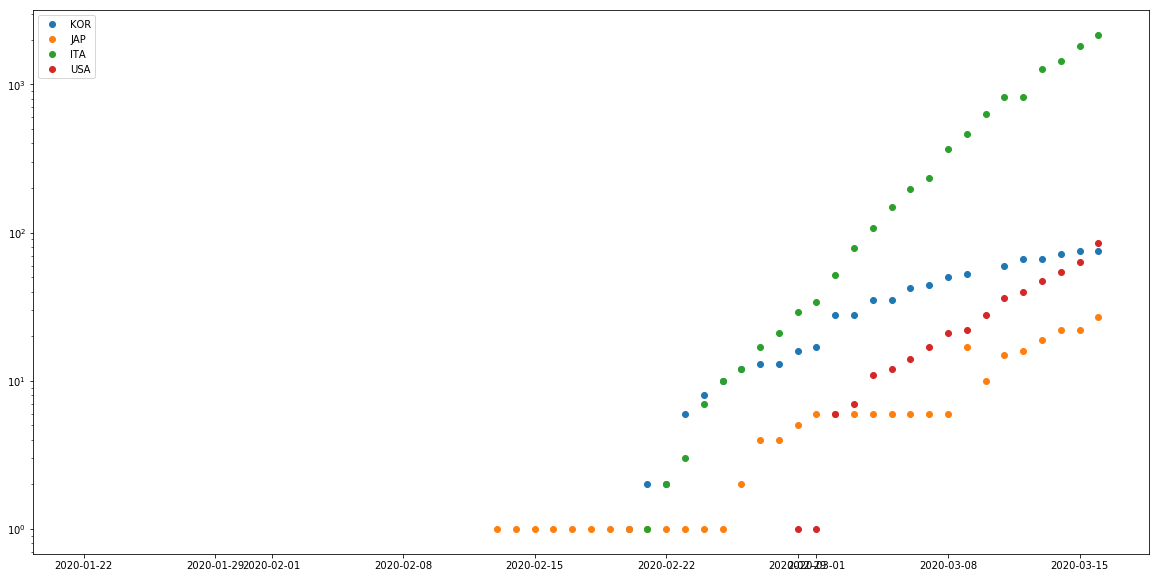

In [20]:
plt.figure(figsize=(20,10))
plt.plot_date(KOR[0], KOR[1][:, 1])
plt.plot_date(JAP[0], JAP[1][:, 1])
plt.plot_date(ITA[0], ITA[1][:, 1])
plt.plot_date(USA[0], USA[1][:, 1])
plt.yscale("log")
plt.legend(["KOR", "JAP", "ITA", "USA"])

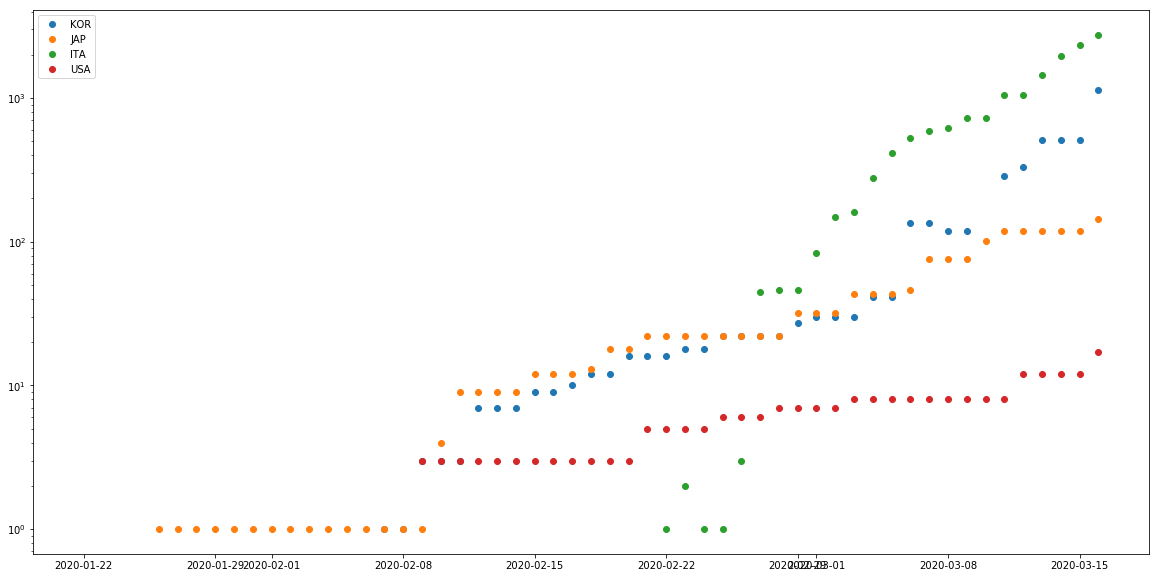

In [21]:
plt.figure(figsize=(20,10))
plt.plot_date(KOR[0], KOR[1][:, 2])
plt.plot_date(JAP[0], JAP[1][:, 2])
plt.plot_date(ITA[0], ITA[1][:, 2])
plt.plot_date(USA[0], USA[1][:, 2])
plt.yscale("log")
plt.legend(["KOR", "JAP", "ITA", "USA"])

In [22]:
WA=extract_region('Washington', 'US')
NY=extract_region('New York', 'US')
CA=extract_region('California', 'US')
MA=extract_region('Massachusetts', 'US')

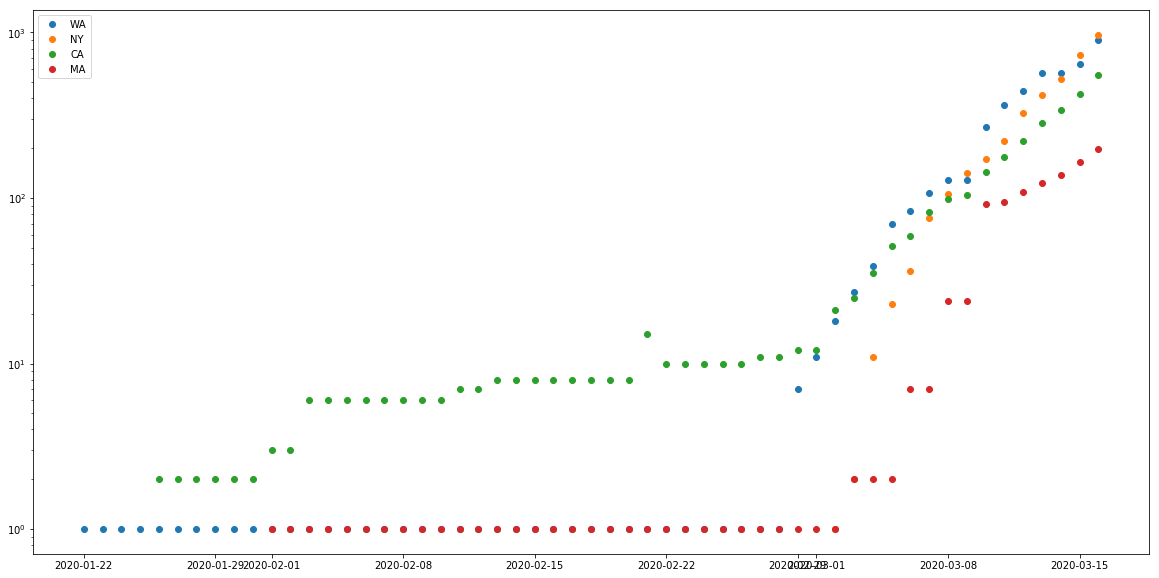

In [23]:
plt.figure(figsize=(20,10))
plt.plot_date(WA[0], WA[1][:, 0])
plt.plot_date(NY[0], NY[1][:, 0])
plt.plot_date(CA[0], CA[1][:, 0])
plt.plot_date(MA[0], MA[1][:, 0])
plt.yscale("log")
plt.legend(["WA", "NY", "CA", "MA"])

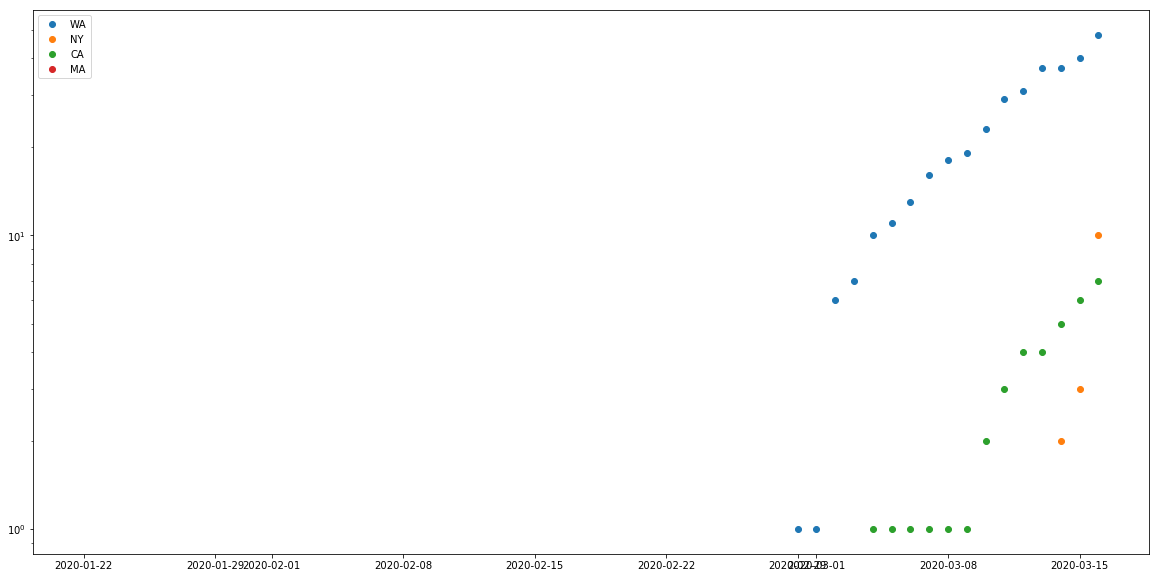

In [24]:
plt.figure(figsize=(20,10))
plt.plot_date(WA[0], WA[1][:, 1])
plt.plot_date(NY[0], NY[1][:, 1])
plt.plot_date(CA[0], CA[1][:, 1])
plt.plot_date(MA[0], MA[1][:, 1])
plt.yscale("log")
plt.legend(["WA", "NY", "CA", "MA"])